In [21]:
! pip install import-ipynb

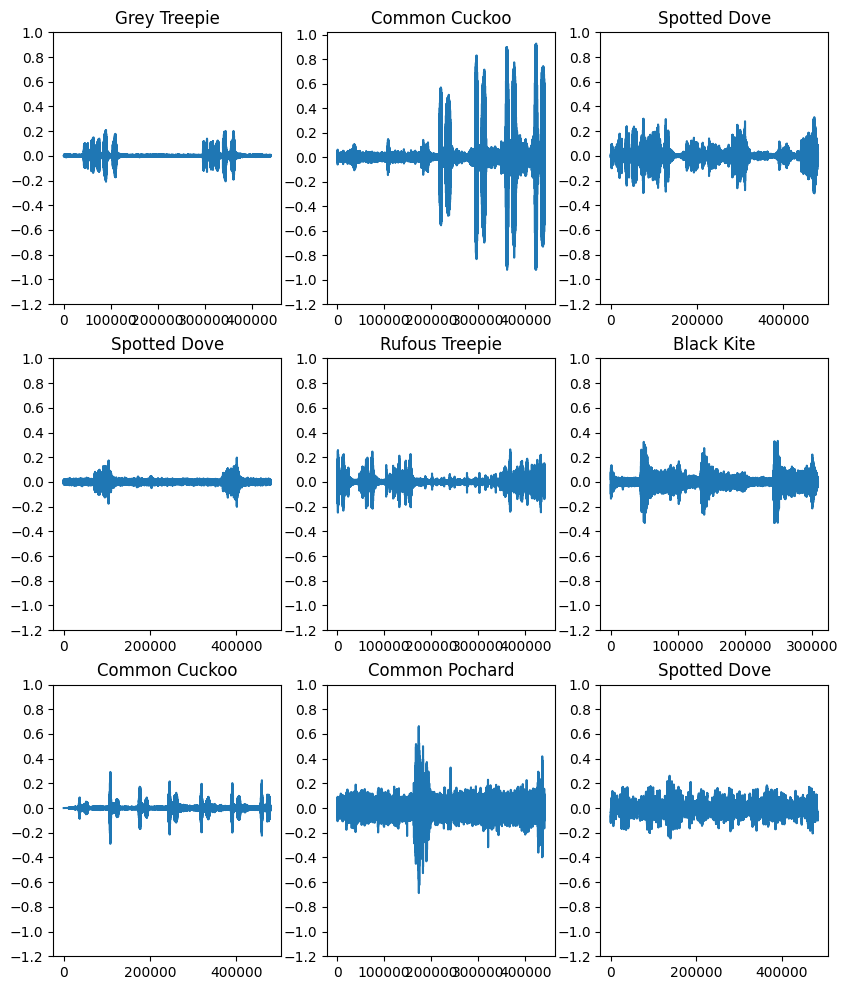

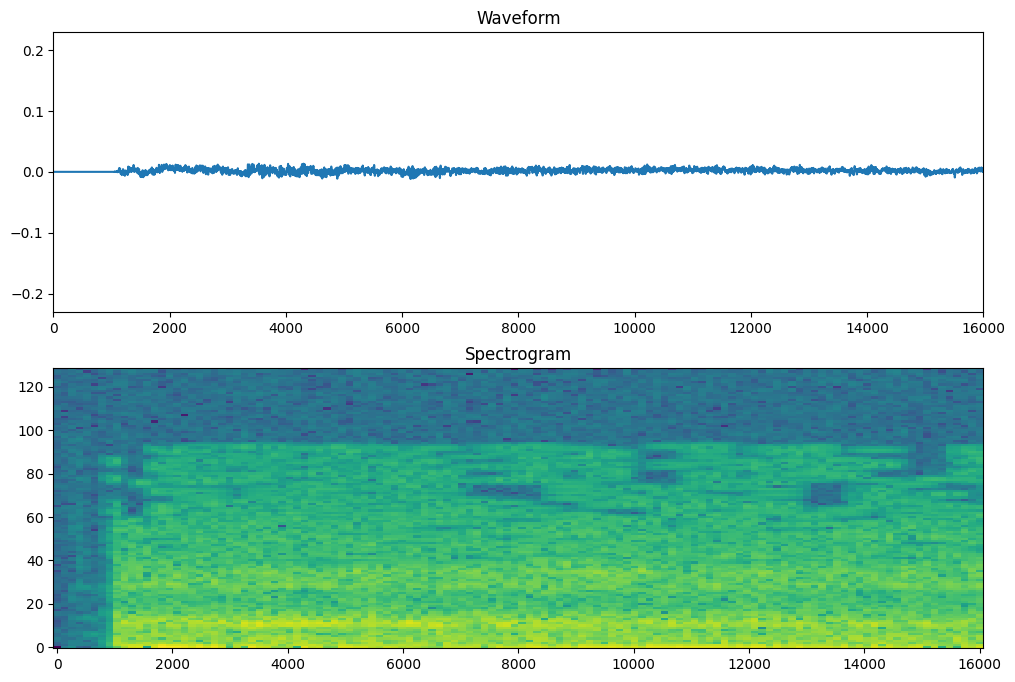

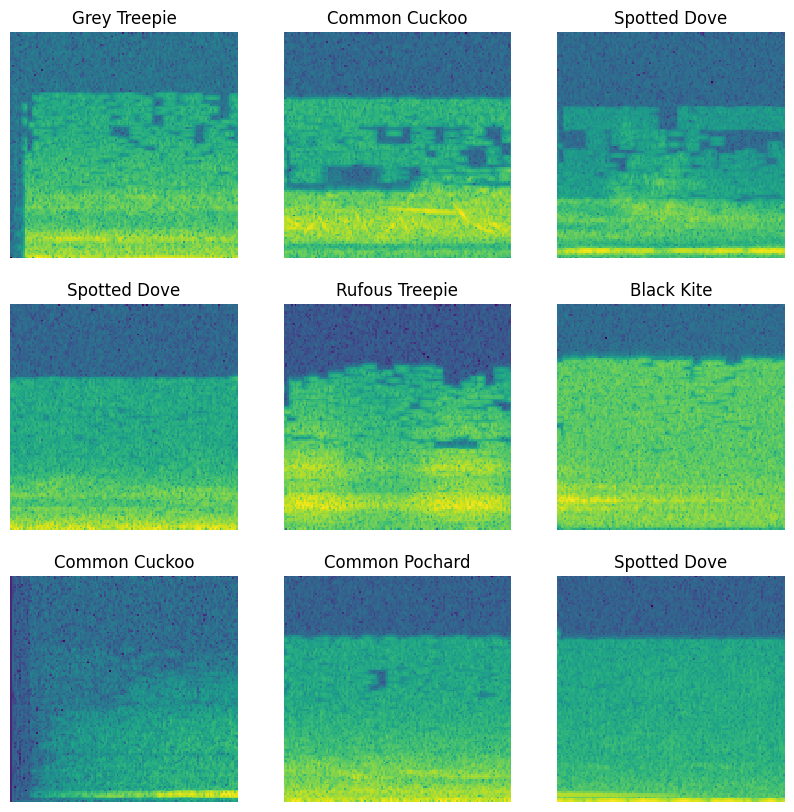

In [22]:
%run extractAudioFiltered.ipynb

In [23]:
RESIZING = 64 # 32 standard 

In [24]:
from tensorflow import keras
from keras import layers
from keras import models

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential(
    [
        layers.Input(shape=input_shape),

        # Downsample the input.
        layers.Resizing(RESIZING, RESIZING),

        # Convolutional layer 1
        layers.Conv2D(RESIZING, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Normalize.
        norm_layer,
        
        # Convolutional layer 2
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        # Convolutional layer 3
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(128, activation="relu"),
        layers.Dropout(0.5),
        # Use softmax activation for multi-class classification
        layers.Dense(num_labels, activation='softmax')
    ]
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing_2 (Resizing)       (None, 64, 64, 1)         0         
                                                                 
 conv2d_6 (Conv2D)           (None, 62, 62, 64)        640       
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 31, 31, 64)        0         
 g2D)                                                            
                                                                 
 normalization_2 (Normaliza  (None, 31, 31, 64)        3         
 tion)                                                           
                                                                 
 conv2d_7 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 14, 14, 64)       

In [25]:
model.compile(
    optimizer           = tf.keras.optimizers.Adam(),
    loss                = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics             = ["accuracy"],
)

In [26]:
EPOCHS = 10
history = model.fit(
    train_ds,
    validation_data     = val_ds,
    epochs              = EPOCHS,
    callbacks           = tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10


C:\Users\romai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\keras\src\backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


69/69 [==============================] - 64s 917ms/step - loss: 2.7359 - accuracy: 0.1000 - val_loss: 2.6401 - val_accuracy: 0.1407
Epoch 2/10
69/69 [==============================] - 13s 186ms/step - loss: 2.6018 - accuracy: 0.1457 - val_loss: 2.4641 - val_accuracy: 0.2111
Epoch 3/10
69/69 [==============================] - 14s 202ms/step - loss: 2.4710 - accuracy: 0.1975 - val_loss: 2.3765 - val_accuracy: 0.2407
Epoch 4/10
69/69 [==============================] - 14s 201ms/step - loss: 2.3826 - accuracy: 0.2296 - val_loss: 2.3081 - val_accuracy: 0.2481
Epoch 5/10
69/69 [==============================] - 14s 203ms/step - loss: 2.2541 - accuracy: 0.2803 - val_loss: 2.2201 - val_accuracy: 0.3259
Epoch 6/10
69/69 [==============================] - 15s 212ms/step - loss: 2.1841 - accuracy: 0.2955 - val_loss: 2.1867 - val_accuracy: 0.3130
Epoch 7/10
69/69 [==============================] - 13s 190ms/step - loss: 2.0989 - accuracy: 0.3315 - val_loss: 2.1521 - val_accuracy: 0.3519
Epoch 8/10

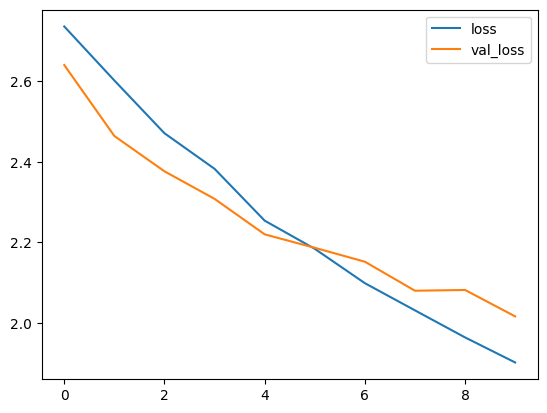

In [27]:
metrics = history.history
plt.plot(history.epoch, metrics["loss"], metrics["val_loss"])
plt.legend(["loss", "val_loss"])
plt.show()

In [28]:
test_audio = []
test_labels = []

for audio, label in test_ds:
    test_audio.append(audio.numpy())
    test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [29]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f"Test set accuracy: {test_acc:.0%}")

18/18 [==============================] - 1s 49ms/step
Test set accuracy: 41%


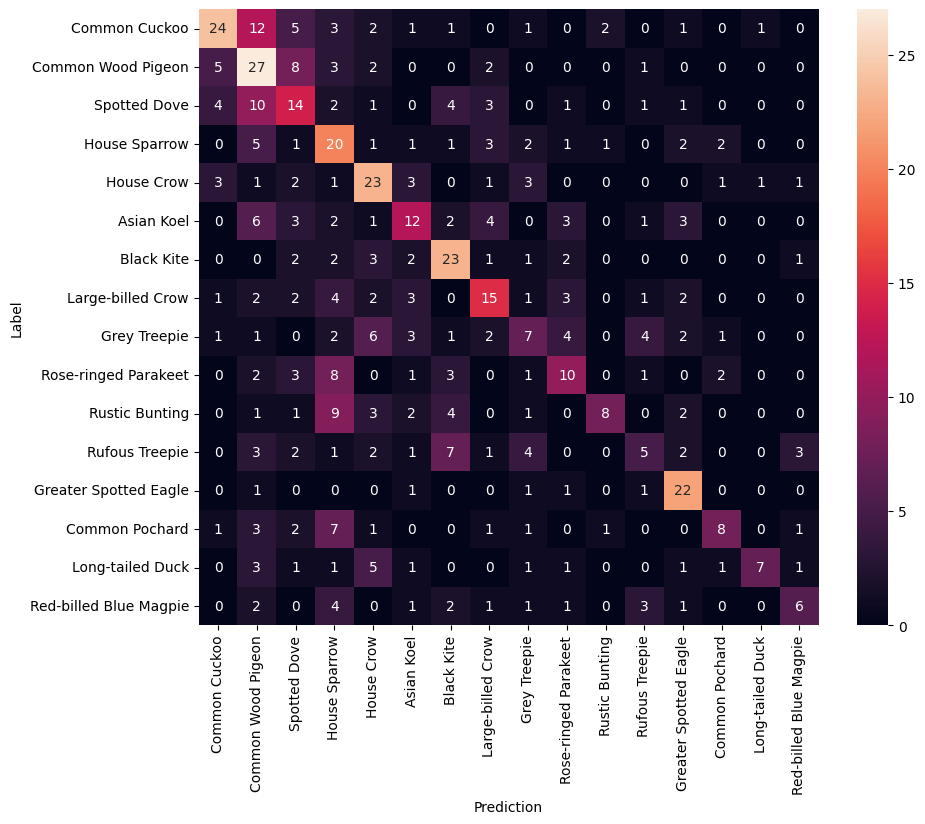

In [30]:
import seaborn as sns

confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(
    confusion_mtx, xticklabels=birds, yticklabels=birds, annot=True, fmt="g"
)
plt.xlabel("Prediction")
plt.ylabel("Label")
plt.show()